# Competition: awake / n-rem / rem

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from keras import layers
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import random as random

trainset_1 = pd.read_csv('EEG_mouse_data_1.csv')
trainset_2 = pd.read_csv('EEG_mouse_data_2.csv')
testset_1 = pd.read_csv('EEG_mouse_data_test.csv')
# trainset_1[trainset_1['state'] == 'w']

In [4]:
supertrainset = pd.concat([trainset_1, trainset_2])
supertrainset.shape

(40863, 102)

In [5]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

def normalize(df):
    scaler = StandardScaler()
    df = scaler.fit_transform(df)

    return df

In [6]:
from sklearn import decomposition


# utiliser ça dans le accu 90%...
#trainset_1 = trainset_1.iloc[:,:26]

X = supertrainset.drop('state', axis=1)
y = supertrainset['state'].map({'w': 2, 'r': 1, 'n': 0})

X = normalize(X)

pca = decomposition.PCA(n_components=10)
pca.fit(X)

X = pca.transform(X)


In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from keras import layers
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.layers import Input
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from keras.regularizers import l1, l2
from keras.layers import Dropout
from keras.optimizers import Adam


# momentum: [0, 0.8, 0.9, 0.99]
# learning_rate: [0.1, 0.01, 0.001, 0.0001]
def create_model_three_class():
   # model = keras.Sequential()
   # model.add(Input(shape=(X.shape[1], 1)))  # Ajouter une couche d'entrée
   # model.add(LSTM(5))
   # model.add(Dense(3, activation='softmax'))
   # model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model = Sequential()
    model.add(Conv1D(filters=40, kernel_size=3, activation='relu', input_shape=(X.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))
    
    #opti = Adam(learning_rate=0.001, beta_1=0.99)
    #model.compile(optimizer=opti, loss='categorical_crossentropy', metrics=['accuracy'])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    #mlp.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.99),loss="mse")
    return model


model = create_model_three_class()
model.summary()


C:\Users\Julien\miniconda3\envs\ARN\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 8, 40)               │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 4, 40)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 160)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │          16,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             303 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,563 (64.70 KB)

 Trainable params: 16,563 (64.70 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# 3 classes
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from keras import layers
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import random as random
from sklearn.utils import class_weight
from keras.utils import to_categorical

# splitting en 3 folds
keras.utils.set_random_seed(123)
kf = KFold(n_splits=3, shuffle=True)

history_list_three_class = []
trained_mlp_three_class = []

# IDEE
# EV. faire un early stop si le loss actuel n'est pas meilleur après 5 epochs!!!
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    
    model = create_model_three_class()
    X_reshaped = X.reshape(X.shape[0], X.shape[1], 1)
    y_one_hot = to_categorical(y, num_classes=3)
    print(f"fold: {fold}")
    history = model.fit(x=X_reshaped[train_index], y=y_one_hot[train_index], 
                        validation_data=(X_reshaped[test_index], y_one_hot[test_index]),
                        batch_size=64,
                        epochs=10)
    
    history_list_three_class.append(history)
    trained_mlp_three_class.append(model)

fold: 0
Epoch 1/10
426/426 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8408 - loss: 1.0242 - val_accuracy: 0.8919 - val_loss: 0.3462
Epoch 2/10
426/426 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8982 - loss: 0.3237 - val_accuracy: 0.8935 - val_loss: 0.3174
Epoch 3/10
426/426 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8991 - loss: 0.3049 - val_accuracy: 0.8943 - val_loss: 0.3085
Epoch 4/10
426/426 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9000 - loss: 0.2984 - val_accuracy: 0.8951 - val_loss: 0.3061
Epoch 5/10
426/426 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8996 - loss: 0.2951 - val_accuracy: 0.8955 - val_loss: 0.3031
Epoch 6/10
426/426 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8988 - loss: 0.2929 - val_accuracy: 0.8948 - val_loss: 0.3041
Epoch 7/10
426/426 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9020 - loss: 0.2910 - val_accuracy: 0.8954 - val_loss: 0.3011
Epoch 8/10
426/426 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9018 - loss: 0.2889 - val_accu

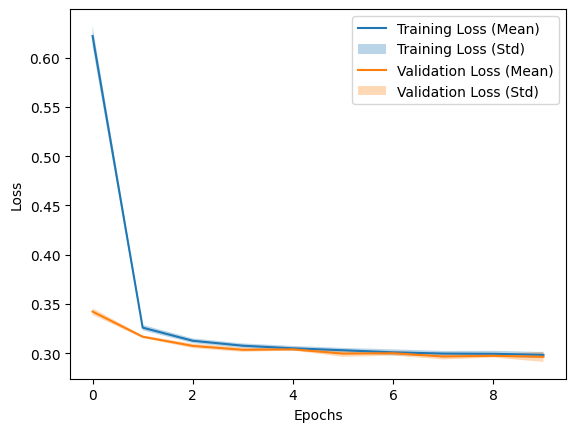

In [9]:
# classes

import numpy as np
import matplotlib.pyplot as pl
train_losses = np.array([history.history['loss'] for history in history_list_three_class])
val_losses = np.array([history.history['val_loss'] for history in history_list_three_class])

# Calculate mean and standard deviation for training and validation losses
mean_train_loss = np.mean(train_losses, axis=0)
std_train_loss = np.std(train_losses, axis=0)
mean_val_loss = np.mean(val_losses, axis=0)
std_val_loss = np.std(val_losses, axis=0)

# Plot mean and standard deviation for training loss
pl.plot(mean_train_loss, label='Training Loss (Mean)')
pl.fill_between(range(len(mean_train_loss)), mean_train_loss - std_train_loss, mean_train_loss + std_train_loss, alpha=0.3, label='Training Loss (Std)')

# Plot mean and standard deviation for validation loss
pl.plot(mean_val_loss, label='Validation Loss (Mean)')
pl.fill_between(range(len(mean_val_loss)), mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, alpha=0.3, label='Validation Loss (Std)')

# Add labels and legend
pl.xlabel('Epochs')
pl.ylabel('Loss')
pl.legend()

# Display the plot
pl.show()

426/426 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
F1 Score - Fold 1: 0.8971441157036928
426/426 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
F1 Score - Fold 2: 0.898612436678658
426/426 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
F1 Score - Fold 3: 0.8968504515086998


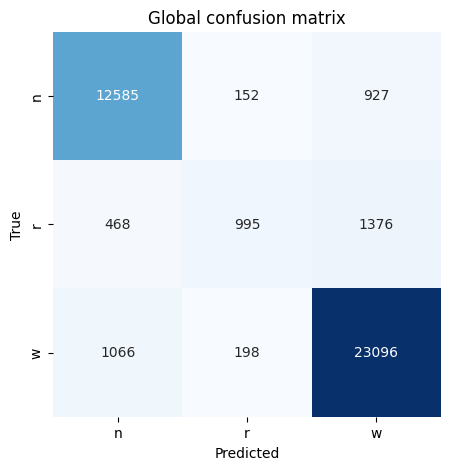

Mean F1 Score across all folds: 0.8975356679636836


In [10]:
# 3 classes

import numpy as np
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

def plot_confusion_matrix(confusion_matrix, title):
    # Plot confusion matrix
    pl.figure(figsize=(5, 5))
    sns.heatmap(confusion_matrix.astype(int), annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["n", "r", "w"], yticklabels=["n", "r", "w"])
    pl.title(title)
    pl.xlabel('Predicted')
    pl.ylabel('True')
    pl.show()

f1_scores = []
mean_confusion_matrix = np.zeros((3, 3))

for i, (train_index, test_index) in enumerate(kf.split(X)):
    # Evaluate the trained model on the test fold
    predicted_probabilities = trained_mlp_three_class[i].predict(X[test_index])
    predictions = np.argmax(predicted_probabilities, axis=1)
    true_labels = y.iloc[test_index]

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    mean_confusion_matrix += confusion_matrix(true_labels, predictions)

    # Compute confusion matrix and plot
    #plot_confusion_matrix(cm, f'Confusion Matrix - Fold {i + 1}')

    # Compute F1 score
    f1 = f1_score(true_labels, predictions, average='micro')
    f1_scores.append(f1)
    print(f"F1 Score - Fold {i + 1}: {f1}")

# Plot mean confusion matrix
plot_confusion_matrix(mean_confusion_matrix, 'Global confusion matrix')

# Calculate and display the mean F1 score across all folds
mean_f1_score = np.mean(f1_scores)
print(f"Mean F1 Score across all folds: {mean_f1_score}")

In [15]:
# produire les prédictions du trainset

import numpy as np
mapping = {2: 'w', 1: 'r', 0: 'n'}

# Remplacer les valeurs dans les prédictions

# en option !
testset_normalized = normalize(testset_1)
testset_normalized = pca.transform(testset_normalized)
#testset_normalized = testset_normalized[:,:26]

# a prendre le meilleur fold
predicted_probabilities = trained_mlp_three_class[1].predict(testset_normalized)
predictions = np.argmax(predicted_probabilities, axis=1)
predictions = np.vectorize(mapping.get)(predictions)
predictions

with open('test_pred.npy', 'wb') as f:
        np.save(f, predictions)




2504/2504 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


In [23]:
# test to open file
#a = open('test_pred.npy', mode='rb')
#print(np.load(a))

['n' 'n' 'n' ... 'n' 'n' 'w']
